# Building Neuron Tensors
Resources that have been useful:
* [key resource] Stanford tutorial: https://cs231n.github.io/convolutional-networks/
* [key resource] Stackexchange that makes all this clear with a simple example: https://stackoverflow.com/questions/52272592/how-many-neurons-does-the-cnn-input-layer-have
----
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/
* https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/
* https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks
* https://hackernoon.com/learning-keras-by-implementing-vgg16-from-scratch-d036733f2d5

In [3]:
# make all possible with two for-loops 
# think about why the results change (FM is tighter when with shifts)
# choose from the same block so that the size is the same (easier to compare)
# 10 FM from the same block

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import InputLayer, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.python.keras import backend as K
import math

* load a pre-trained network (VGG16)
* input images from CIFAR-10 to VGG16
* choose some random unit in one of the layers and plot its activity for different images

## Load VGG16 model

In [5]:
from keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, weights='imagenet',input_shape=(32,32,3))
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [6]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(10, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

## Load CIFAR-10 Data

In [8]:
from tensorflow.python.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data() #load dataset into ~/.keras/datasets/

#printout shapes of train and test data
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


In [9]:
N_train = 50000
N_test = 10000
img_shape = (32, 32, 3) #use a tuple in the fomat: (height, width, n_channels)
n_classes = 9
print(N_train,N_test,img_shape,n_classes)

50000 10000 (32, 32, 3) 9


In [10]:
## normalize the images 
x_train.dtype ##int from 0 to 255
x_train = x_train / 255.0
x_train.dtype

dtype('float64')

In [11]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [12]:
idx = (y_train == 3).reshape(x_train.shape[0])
images_cat = x_train[idx]
images_cat[0]

array([[[0.49019608, 0.49019608, 0.45490196],
        [0.43137255, 0.39607843, 0.35686275],
        [0.4       , 0.35294118, 0.3254902 ],
        ...,
        [0.79215686, 0.81176471, 0.83921569],
        [0.78431373, 0.80392157, 0.83137255],
        [0.79215686, 0.81568627, 0.83921569]],

       [[0.55686275, 0.57254902, 0.55686275],
        [0.57254902, 0.56470588, 0.54509804],
        [0.69019608, 0.6745098 , 0.66666667],
        ...,
        [0.76470588, 0.78823529, 0.80392157],
        [0.77647059, 0.80392157, 0.81960784],
        [0.8       , 0.82745098, 0.84313725]],

       [[0.70588235, 0.7254902 , 0.71764706],
        [0.56078431, 0.57254902, 0.57254902],
        [0.61176471, 0.61568627, 0.61568627],
        ...,
        [0.47843137, 0.43529412, 0.44313725],
        [0.54509804, 0.50196078, 0.51372549],
        [0.61960784, 0.57647059, 0.58823529]],

       ...,

       [[0.40784314, 0.32156863, 0.16078431],
        [0.39607843, 0.31372549, 0.15294118],
        [0.39607843, 0

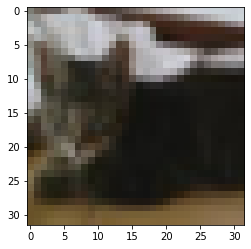

In [13]:
plt.imshow(images_cat[0])

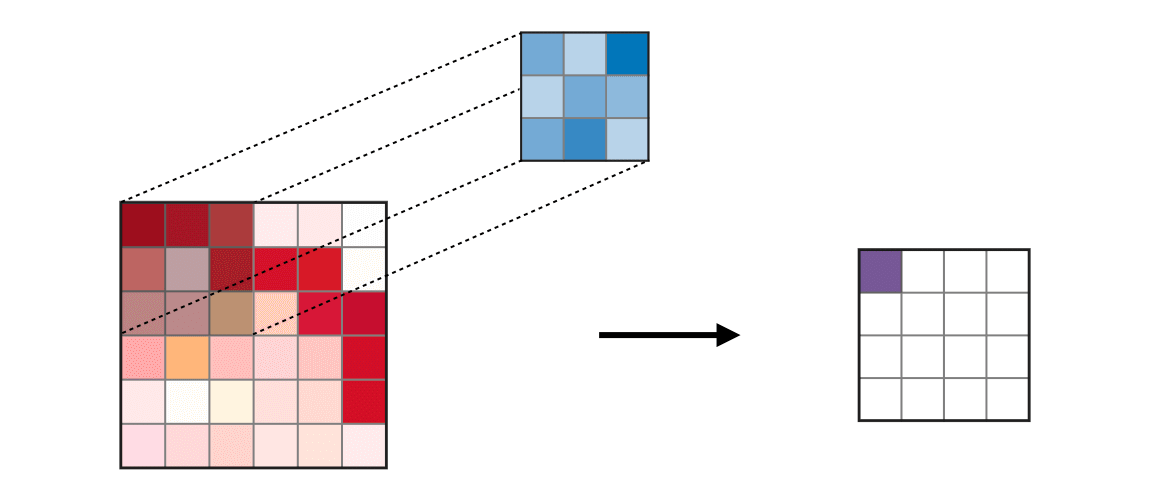

### Applying shifts:
* shift_step = 3, which is the filter size
* shift the images such that each filter eventually capture all pixels

In [14]:
def apply_all_shifts(im, shift_step):
    '''
    arg(s): 
        im, an image of shape (im_size, im_size, 3)
    return: 
        im_all_shifts, a list of all shifted images from the input image
        n_shifts, number of shifted images
    '''
    
    ## vertical size might not be the same as the horizontal
    im_size_vertical = im.shape[0]
    im_size_horizontal = im.shape[1]
    
    n_shifts_vertical = int(math.ceil(im_size_vertical/ shift_step))
    n_shifts_horizontal = int(math.ceil(im_size_horizontal/ shift_step))
    
    im_all_shifts = []
    im_shift = im
    for i in range(n_shifts_vertical):
        im_shift = np.roll(im_shift, shift = shift_step * i, axis=0)
        
        for j in range(n_shifts_horizontal):
            im_shift = np.roll(im_shift, shift = shift_step * j, axis=1)
            im_all_shifts.append(im_shift)
            
    im_all_shifts =  np.array(im_all_shifts)
    return im_all_shifts, n_shifts_vertical * n_shifts_horizontal

Text(0.5, 0.98, 'Visualizing Some Shifts (shift_step = 2)')

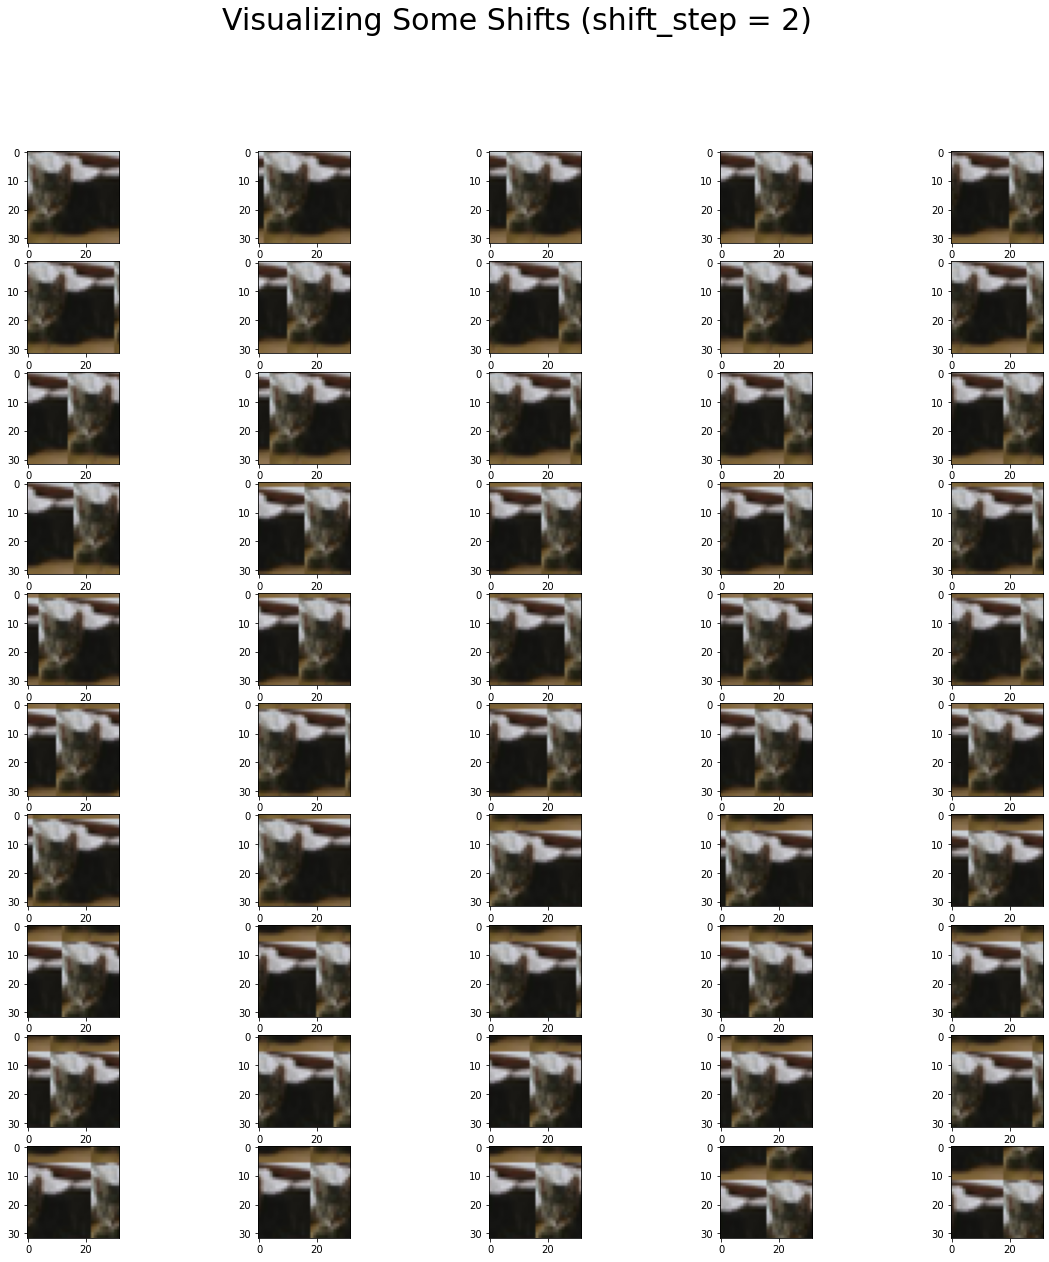

In [15]:
## check the shifted images
im1 = images_cat[0]
im_all_shifts, n_shifts = apply_all_shifts(im1,2)
# nrow = int(n_shifts/5)

fig, axs = plt.subplots(10, 5, figsize =  (20,20))
for i , ax in enumerate(axs.flatten()):
    ax.imshow(im_all_shifts[i])
fig.suptitle('Visualizing Some Shifts (shift_step = 2)', fontsize=30)


In [16]:
im_all_shifts.shape

(256, 32, 32, 3)

In [17]:
n_shifts

256

### Function to compute neuron output (neuron dimension):
#### For each layer in the neural network, choose one feature map with the highest average firing rate:

In [19]:
def compute_neuron_output(layer_indices, images, plot_activity = False):

    '''
    arg(s):
        layer_indices: list of the indices of the layers we want to take neuron outputs from
        images: an array of images (stimuli)
    return:
        
    '''
    n_layers = len(layer_indices)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    
    for layer_index in layer_indices:
        layer = model.layers[layer_index] 
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        ## note: always take the images as inputs
        output_layer = K.function(inputs=[model.layers[1].input], 
                              outputs=[layer.output])
        
        ## output is n feature maps
        neuron_output = output_layer(images)[0]
   
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        neuron_output = neuron_output.reshape((n_images, n_row * n_col, n_feature_maps))
        
        neuron_labels += [layer_index] * n_row * n_col
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = np.transpose(neuron_output, (0, 2, 1)) 
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if layer_index == 1:
            fm_avg_all_layers = fm_avg
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
        
        max_fm_ind = np.argmax(fm_avg,axis = 1)
        
        
        if plot_activity == True:
            print("Current layer: " + layer.name)
            print("Indices of FM with highest average firing rate in response to each image: " )
            print(max_fm_ind)
            print("#neurons in the FM with highest average firing rate: " + str(n_row * n_col))
            print("Average activity for all feature maps in " + layer.name)
            plt.matshow(fm_avg)
            plt.show()
            print('----------------------------------------------------\n')
        
        temp = neuron_output_by_fm[0,max_fm_ind[0],:].reshape(1, n_row * n_col)
        for i in range(1,n_images):
            temp = np.vstack((temp, neuron_output_by_fm[i,max_fm_ind[i],:].reshape(1, n_row * n_col)))
        if(layer_index == 1): 
            neuron_output_highest = temp
        else:
            neuron_output_highest = np.hstack((neuron_output_highest, temp))
    
    neuron_labels = np.array(neuron_labels)     
    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

#### Among all feature maps in the specified layers, choose the top ten feature maps with the highest average firing rate:

In [20]:
 def compute_neuron_output_alt(layer_indices, images, plot_activity = False):

    '''
    arg(s):
        layer_indices: list of the indices of the layers we want to take neuron outputs from
        images: an array of images (stimuli)
    return:
        
    '''
    n_layers = len(layer_indices)
    neuron_output_highest = []
    all_fm_avg = []
    neuron_labels = []
    pos = 0
    for layer_index in layer_indices:
        layer = model.layers[layer_index] 
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
            
        pos += 1
        ## note: always take the images as inputs
        output_layer = K.function(inputs=[model.layers[1].input], 
                              outputs=[layer.output])
        
        ## output is n feature maps
        neuron_output = output_layer(images)[0]
   
        ## number of neurons is nrow * ncol * n_feature_maps
        n_images, n_row, n_col, n_feature_maps = neuron_output.shape[:]
        n_neurons = n_row * n_col
        neuron_output = neuron_output.reshape((n_images, n_neurons, n_feature_maps))
    
        
        ## transpose to organize by feature maps
        ## neuron_output_by_fm is (n_images, n_feature_maps, #neurons)
        neuron_output_by_fm = np.transpose(neuron_output, (0, 2, 1)) 
        
        ## compute avg neuron firing rate in each feature map
        ## fm_avg is (n_images, n_feature_maps)
        fm_avg = neuron_output_by_fm.sum(axis=2) / neuron_output_by_fm.shape[2]
        
        if pos == 1:
            fm_avg_all_layers = fm_avg
            neuron_output_by_fm_all_layers = neuron_output_by_fm
        else:
            fm_avg_all_layers = np.hstack((fm_avg_all_layers, fm_avg))
            neuron_output_by_fm_all_layers = np.concatenate((neuron_output_by_fm_all_layers,neuron_output_by_fm), axis = 1)

    neuron_output_highest = np.empty((n_images,n_neurons *10))
    for i in range(n_images):
        max10_indices = np.argpartition(fm_avg_all_layers[i], -10, axis = 0)[-10:]
        neuron_output_highest[i] = neuron_output_by_fm_all_layers[i, max10_indices, :].reshape((1,n_neurons *10))
    
    for i in range(10):    
        neuron_labels += [i] * n_neurons
        
    neuron_labels = np.array(neuron_labels)     
    return neuron_output_highest, fm_avg_all_layers, neuron_labels 

### Function to get images (stimuli dimension):

In [21]:
def show_stimuli(layer_indices, n_images_per_class, image_classes, shifts, plot_activity = False):
    '''
    arg(s): 
        layer_indices
        n_images_per_class
        image_classes
        shifts = True/False
    return:
        neuron_output_shifts_avg, (n_images, n_neurons)
    '''
    # select images from specified classes:
    
    n_classes = len(image_classes)
    n_images = n_classes * n_images_per_class
    
    for i in range(n_classes):
        idx = (y_train == image_classes[i]).reshape(x_train.shape[0])
        images = x_train[idx]
        ## images has shape (5000, 32, 32, 3), take the first n_images_per_class images from each selected class:
        images = images[0:n_images_per_class,:,:,:]
        if i == 0:
            images_selected_classes = images
        else:
            images_selected_classes = np.vstack((images_selected_classes, images))
    
    images_selected_classes = np.array(images_selected_classes)
    
    if shifts is False:
        neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_indices, images_selected_classes, plot_activity = plot_activity)
    
    else:
        # generate shifts for each selected image: 
        neuron_output_highest_with_shifts = []
        fm_avg_all_layers_with_shifts = []
        for i in range(n_images):
            im = images_selected_classes[i]
            im_all_shifts, n_shifts =  apply_all_shifts(im, 1)

            neuron_output_highest, fm_avg_all_layers, neuron_labels = compute_neuron_output_alt(layer_indices, im_all_shifts, plot_activity = False)
            ## neuron_output_highest is of shape (number of shifts, neurons)

            ## take the average over all shifts of im
            shifts_avg = neuron_output_highest.sum(axis=0) / neuron_output_highest.shape[0]
            shifts_avg = shifts_avg.reshape((1,shifts_avg.shape[0]))
            
            fm_shifts_avg = fm_avg_all_layers.sum(axis=0) / fm_avg_all_layers.shape[0]
            fm_shifts_avg = fm_shifts_avg.reshape((1,fm_shifts_avg.shape[0]))
            
            if i == 0:
                neuron_output_highest_with_shifts = shifts_avg 
                fm_avg_all_layers_with_shifts = fm_shifts_avg
            else:
                neuron_output_highest_with_shifts = np.vstack((neuron_output_highest_with_shifts, shifts_avg))
                fm_avg_all_layers_with_shifts = np.vstack((fm_avg_all_layers_with_shifts, fm_shifts_avg))
                
        neuron_output_highest = neuron_output_highest_with_shifts
        fm_avg_all_layers = fm_avg_all_layers_with_shifts
 
    return neuron_output_highest, fm_avg_all_layers, neuron_labels

In [22]:
neuron_output_highest_with_shifts, fm_avg_all_layers_with_shifts, neuron_labels= show_stimuli(layer_indices = range(3), n_images_per_class = 10, image_classes = range(10), shifts = True)

In [27]:
neuron_output_highest_with_shifts.shape

(100, 10240)

In [28]:
fm_avg_all_layers_with_shifts.shape

(100, 128)

In [29]:
neuron_labels

array([0, 0, 0, ..., 9, 9, 9])

In [30]:
from sklearn.decomposition import PCA
pca = PCA(10)
neuron_output_highest_with_shifts_projected = pca.fit_transform(neuron_output_highest_with_shifts.T)
neuron_output_highest_with_shifts_projected.shape
# pca.fit(neuron_output_highest)
vectors, lambdas = pca.components_, pca.explained_variance_

In [43]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
traces = []
colors_palette = px.colors.qualitative.Dark24
data = neuron_output_highest_with_shifts_projected

for i, label in enumerate(set(neuron_labels)):
    mask = (neuron_labels == label)
    print(label, sum(mask))
    traces.append(go.Scatter3d(
        x=data[mask,0],
        y=data[mask,1],
        z=data[mask,2],
        mode='markers',
        marker=dict(
            size=4,
            color=colors_palette[i],
            opacity=1,

            #showscale= True,
        )))

for trace in traces:
    fig.add_trace(trace)

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0),showlegend=True,)
fig.show()

0 1024
1 1024
2 1024
3 1024
4 1024
5 1024
6 1024
7 1024
8 1024
9 1024


### Embedding with neurons as points (TDA), with shifts:

In [36]:
import persim
# Basic imports 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
# from IPython.display import Video

# scikit-tda imports..... Install all with -> pip install scikit-tda
#--- this is the main persistence computation workhorse
import ripser
# from persim import plot_diagrams
import persim
# import persim.plot

# teaspoon imports...... Install with -> pip install teaspoon
#---these are for generating data and some drawing tools 
import teaspoon.MakeData.PointCloud as makePtCloud
import teaspoon.TDA.Draw as Draw

#---these are for generating time series network examples
from teaspoon.SP.network import ordinal_partition_graph
from teaspoon.TDA.PHN import PH_network
from teaspoon.SP.network_tools import make_network
from teaspoon.parameter_selection.MsPE import MsPE_tau
import teaspoon.MakeData.DynSysLib.DynSysLib as DSL

import kmapper as km
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from kmapper import jupyter 
import pydiffmap
from pydiffmap import diffusion_map as dm
from pydiffmap.visualization import embedding_plot, data_plot

# import dionysus as ds
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import pylab as pl
from matplotlib import collections  as mc
from sklearn.datasets import load_digits
from skimage.morphology import skeletonize
import math
import sys

from gudhi.wasserstein import wasserstein_distance
from gudhi.hera import wasserstein_distance as hera
from sklearn.manifold import SpectralEmbedding

class Barcode:
    __doc__ = """
        Barcode visualisation made easy!
        Note that this convenience class requires instantiation as the number
        of subplots produced depends on the dimension of the data.
        """

    def __init__(self, diagrams, verbose=False):
        """
        Parameters
        ===========
        diagrams: list-like
            typically the output of ripser(nodes)['dgms']
        verbose: bool
            Execute print statemens for extra information; currently only echoes
            number of bars in each dimension (Default=False).
        Examples
        ===========
        >>> n = 300
        >>> t = np.linspace(0, 2 * np.pi, n)
        >>> noise = np.random.normal(0, 0.1, size=n)
        >>> data = np.vstack([((3+d) * np.cos(t[i]+d), (3+d) * np.sin(t[i]+d)) for i, d in enumerate(noise)])
        >>> diagrams = ripser(data)
        >>> bc = Barcode(diagrams['dgms'])
        >>> bc.plot_barcode()
        """
        if not isinstance(diagrams, list):
            diagrams = [diagrams]

        self.diagrams = diagrams
        self._verbose = verbose
        self._dim = len(diagrams)

    def plot_barcode(self, figsize=None, show=True, export_png=False, dpi=100, **kwargs):
        """Wrapper method to produce barcode plot
        Parameters
        ===========
        figsize: tuple
            figure size, default=(6,6) if H0+H1 only, (6,4) otherwise
        show: boolean
            show the figure via plt.show()
        export_png: boolean
            write image to png data, returned as io.BytesIO() instance,
            default=False
        **kwargs: artist paramters for the barcodes, defaults:
            c='grey'
            linestyle='-'
            linewidth=0.5
            dpi=100 (for png export)
        Returns
        ===========
        out: list or None
            list of png exports if export_png=True, otherwise None
        """
        if self._dim == 2:
            if figsize is None:
                figsize = (6, 6)

            return self._plot_H0_H1(
                figsize=figsize,
                show=show,
                export_png=export_png,
                dpi=dpi,
                **kwargs
            )

        else:
            if figsize is None:
                figsize = (6, 4)

            return self._plot_Hn(
                figsize=figsize,
                show=show,
                export_png=export_png,
                dpi=dpi,
                **kwargs
            )

    def _plot_H0_H1(self, *, figsize, show, export_png, dpi, **kwargs):
        out = []

        fig, ax = plt.subplots(2, 1, figsize=figsize)

        for dim, diagram in enumerate(self.diagrams):
            self._plot_many_bars(dim, diagram, dim, ax, **kwargs)

        if export_png:
            fp = io.BytesIO()
            plt.savefig(fp, dpi=dpi)
            fp.seek(0)

            out += [fp]

        if show:
            plt.show()
        else:
            plt.close()

        if any(out):
            return out

    def _plot_Hn(self, *, figsize, show, export_png, dpi, **kwargs):
        out = []

        for dim, diagram in enumerate(self.diagrams):
            fig, ax = plt.subplots(1, 1, figsize=figsize)

            self._plot_many_bars(dim, diagram, 0, [ax], **kwargs)

            if export_png:
                fp = io.BytesIO()
                plt.savefig(fp, dpi=dpi)
                fp.seek(0)

                out += [fp]

            if show:
                plt.show()
            else:
                plt.close()

        if any(out):
            return out

    def _plot_many_bars(self, dim, diagram, idx, ax, **kwargs):
        number_of_bars = len(diagram)
        if self._verbose:
            print("Number of bars in dimension %d: %d" % (dim, number_of_bars))

        if number_of_bars > 0:
            births = np.vstack([(elem[0], i) for i, elem in enumerate(diagram)])
            deaths = np.vstack([(elem[1], i) for i, elem in enumerate(diagram)])

            inf_bars = np.where(np.isinf(deaths))[0]
            max_death = deaths[np.isfinite(deaths[:, 0]), 0].max()

            number_of_bars_fin = births.shape[0] - inf_bars.shape[0]
            number_of_bars_inf = inf_bars.shape[0]

            _ = [self._plot_a_bar(ax[idx], birth, deaths[i], max_death, **kwargs) for i, birth in enumerate(births)]

        # the line below is to plot a vertical red line showing the maximal finite bar length
        ax[idx].plot(
            [max_death, max_death],
            [0, number_of_bars - 1],
            c='r',
            linestyle='--',
            linewidth=0.7
        )

        title = "H%d barcode: %d finite, %d infinite" % (dim, number_of_bars_fin, number_of_bars_inf)
        ax[idx].set_title(title, fontsize=9)
        ax[idx].set_yticks([])

        for loc in ('right', 'left', 'top'):
            ax[idx].spines[loc].set_visible(False)

    @staticmethod
    def _plot_a_bar(ax, birth, death, max_death, c='gray', linestyle='-', linewidth=0.5):
        if np.isinf(death[0]):
            death[0] = 1.05 * max_death
            ax.plot(
                death[0],
                death[1],
                c=c,
                markersize=4,
                marker='>',
            )

        ax.plot(
            [birth[0], death[0]],
            [birth[1], death[1]], 
            c=c,
            linestyle=linestyle,
            linewidth=linewidth,
        )


def drawTDAtutorial(P,diagrams):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (20,5))
#     R = 2
    # Draw diagrams
    plt.sca(axes[0])
    plt.title('0-dim Diagram')
    Draw.drawDgm(diagrams[0])
    R = max(diagrams[0][1])
    plt.axis([0,R,0,R])
    
    plt.sca(axes[1])
    plt.title('1-dim Diagram')
    Draw.drawDgm(diagrams[1])
    R = max(diagrams[1][1])
    plt.axis([0,R,0,R])
    
#     plt.sca(axes[2])
#     plt.title('2-dim Diagram')
#     Draw.drawDgm(diagrams[2])
#     plt.axis([0,R,0,R])

def diffusion_tda(X):
  ## diffusion map with automatic epsilon detection:
    mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 3, alpha = 1, epsilon =  1.0 , k=100)

  # Fit to and transform the data
    X_dmap = mydmap.fit_transform(X)
  
    embedding_plot(mydmap, dim=3, scatter_kwargs = {'c': X_dmap[:,0], 'cmap': 'Spectral'})
    data_plot(mydmap, dim=3, scatter_kwargs = {'cmap': 'Spectral'})
    plt.show()
    print("SHAPE",X_dmap.shape)

    ax = plt.axes(projection ="3d")
    ax.scatter3D(X_dmap[:,0], X_dmap[:,1], X_dmap[:,2])
    plt.show()

    X_diagrams = ripser.ripser(X_dmap, maxdim = 1)['dgms']

  ## draw persistence diagrams
    drawTDAtutorial(X_dmap,X_diagrams) 

  ## draw persistence barcodes
    Barcode(X_diagrams).plot_barcode()
    
    return X_diagrams, Barcode(X_diagrams)

def spectral_tda(X):
    
    embedding = SpectralEmbedding(n_components=3)
    X_projected = embedding.fit_transform(X)
    
    X_diagrams = ripser.ripser(X_projected, maxdim = 2)['dgms']

  ## draw persistence diagrams
    drawTDAtutorial(X_dmap,X_diagrams,R=0.1) 

  ## draw persistence barcodes
    Barcode(X_diagrams).plot_barcode()
    
    return X_diagrams, Barcode(X_diagrams)

def iso_tda(X):
    # Initialize
    mapper = km.KeplerMapper(verbose=2)

    # Fit to and transform the data
#     projected_X = mapper.fit_transform(X,
#     projection=[
#                 # TruncatedSVD(n_components=100,
#                 #              random_state=1729),
#                 Isomap(n_components=2)],
#     scaler=[None, None, MinMaxScaler()])
    projected_X = X
    X_diagrams = ripser.ripser(projected_X, maxdim = 1)['dgms']

  ## draw persistence diagrams
    drawTDAtutorial(X,X_diagrams) 

  ## draw persistence barcodes
    Barcode(X_diagrams).plot_barcode()
    
    return X_diagrams, Barcode(X_diagrams)

def pairwise_Wasserstein(X_diagrams):
# X_diagrams = []
# X_diagrams.append(X1_diagrams)
# X_diagrams.append(X2_diagrams)
# X_diagrams.append(X3_diagrams)
# X_diagrams.append(X4_diagrams)
# X_diagrams.append(X5_diagrams)
# X_diagrams.append(X6_diagrams)

    pd_gudhi = np.zeros((6,6))
    for dim in range(3):
        for i in range(6):
            for j in range(6):
                if i != j:
                    pd_gudhi[i,j] = hera(X_diagrams[i][dim], X_diagrams[j][dim],internal_p=2)
                    print('Wasserstein distance between persistence diagrams for' + str(i+1) +' and '+ str(j+1) + ' (H' + str(dim) + ') is: \n')
                    print(pd_gudhi[i,j] )
                    

In [37]:
data = neuron_output_highest_with_shifts.T
data.shape

(10240, 100)

In [50]:
!pip install tadasets

You should consider upgrading via the 'c:\users\ifisa\anaconda3\python.exe -m pip install --upgrade pip' command.


In [5]:
import tadasets
import numpy as np
import matplotlib.pyplot as plt

In [7]:
dsphere = tadasets.dsphere(n=1000, d=12, r=3.14, ambient=14, noise=0.14)
ax = plt.axes(projection ="3d")
ax.scatter3D(dsphere[:,0], dsphere[:,1], dsphere[:,2])
plt.show()

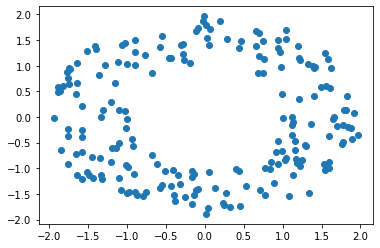

In [54]:
r = 1
R = 2
P = makePtCloud.Annulus(N=200, r=r, R=R, seed=None) # teaspoon data generation
plt.scatter(P[:,0],P[:,1])
# print(P)
# print(type(P))
# print(P.shape)

KeplerMapper(verbose=2)


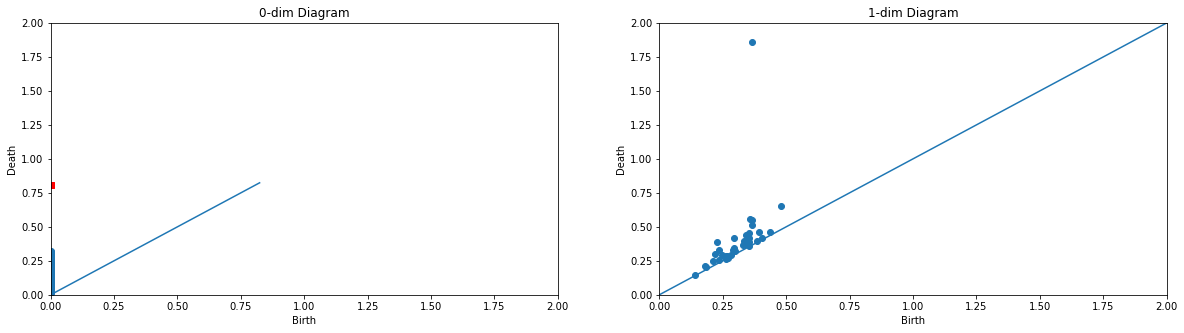

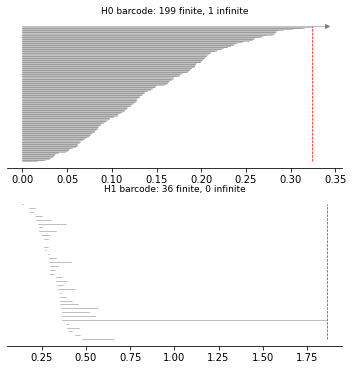

In [71]:
P_diagram, P_barcode = iso_tda(P)

### for block3:

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



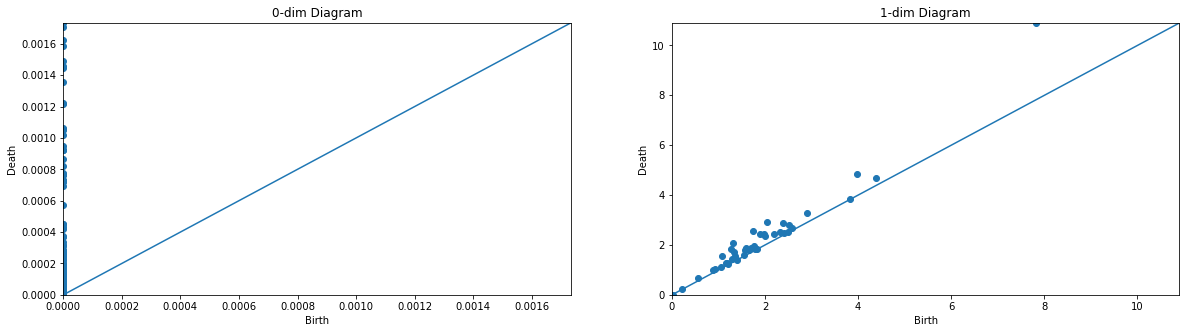

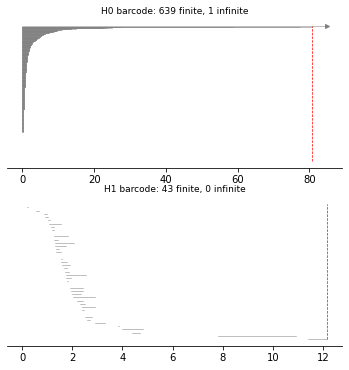

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



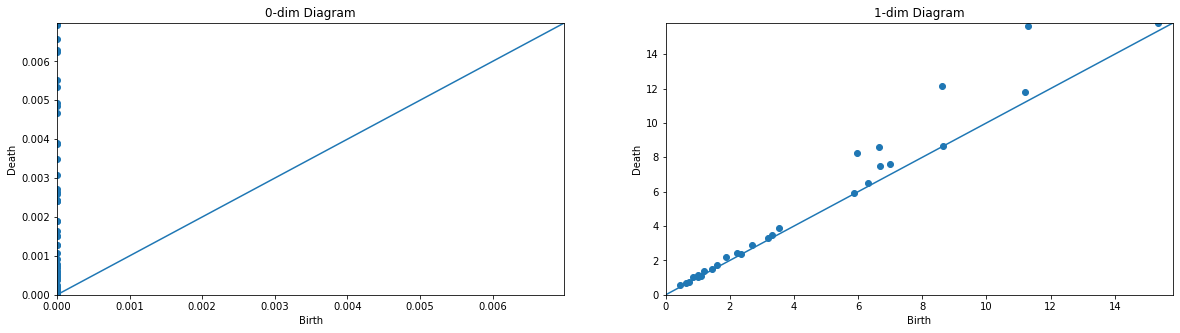

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



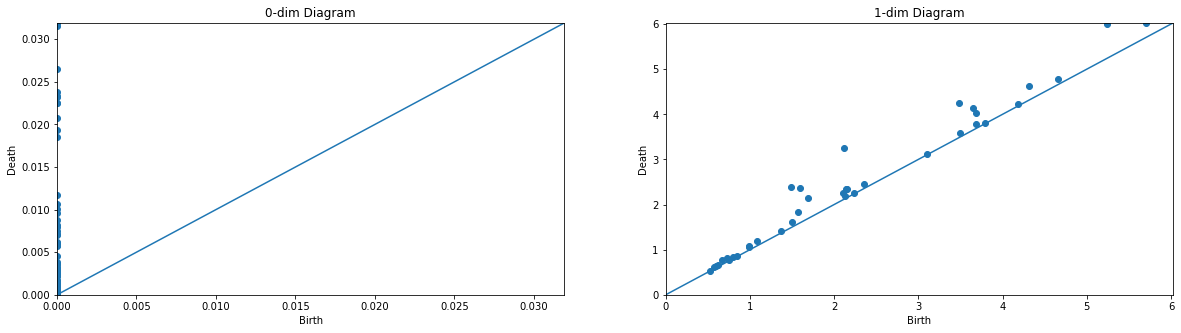

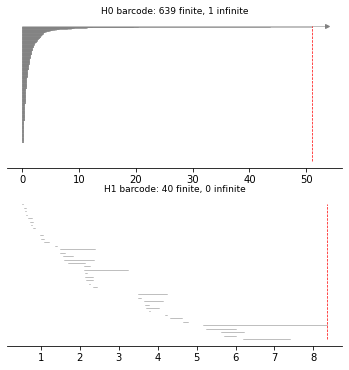

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



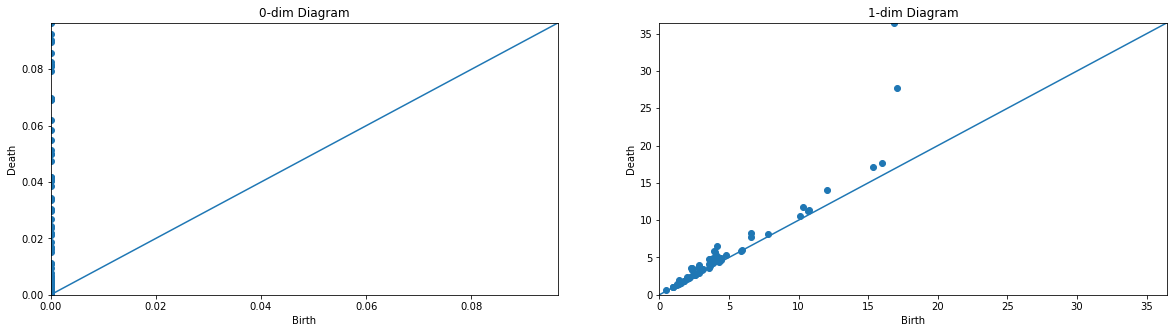

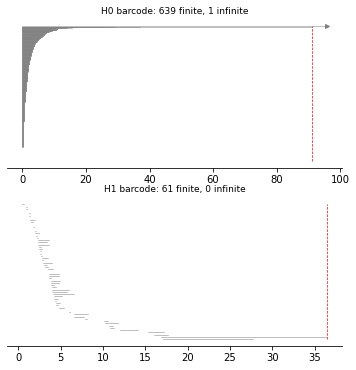

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



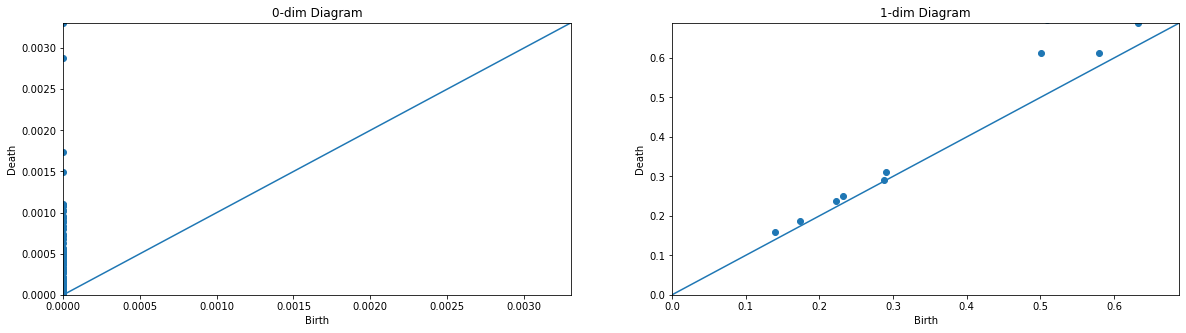

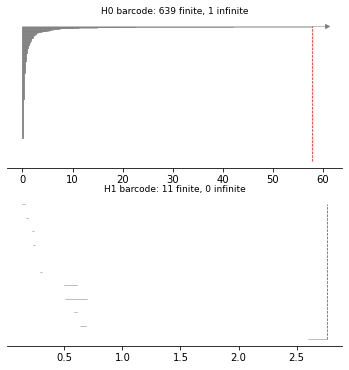

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



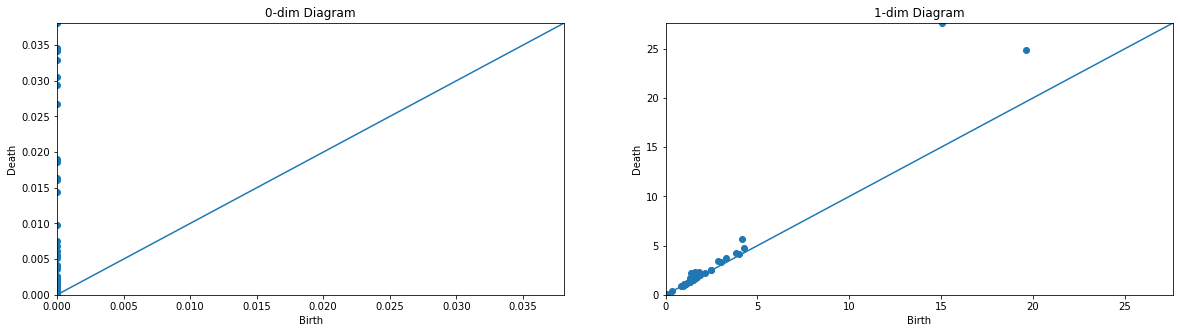

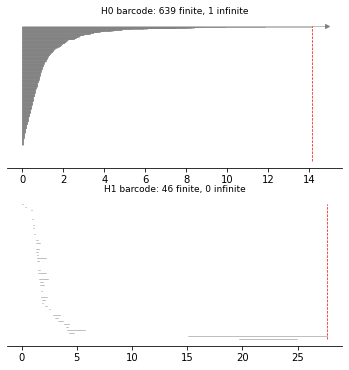

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



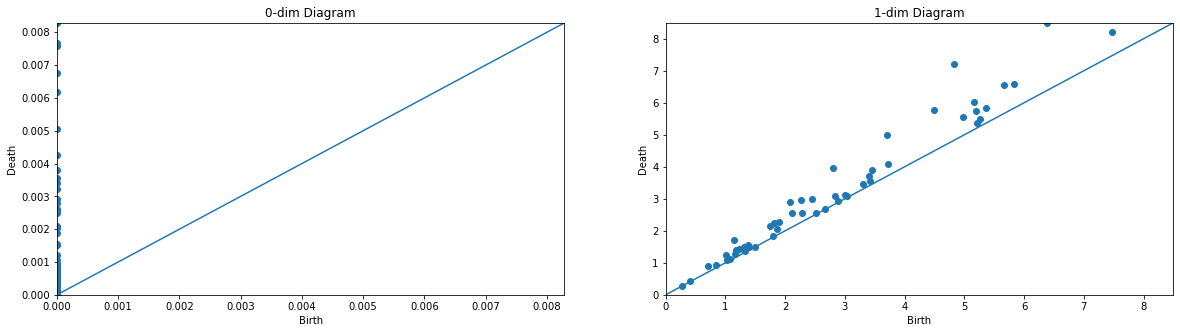

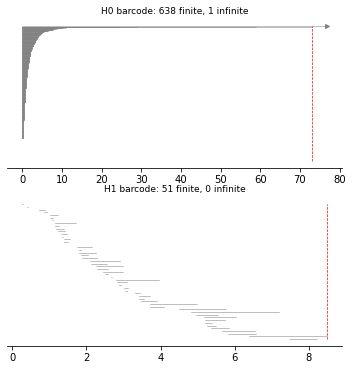

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (640, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



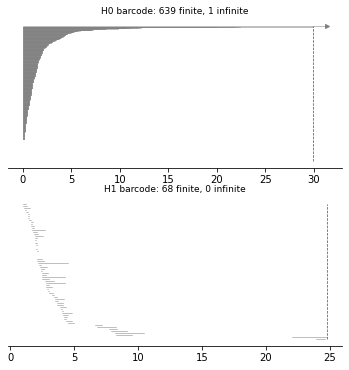

In [69]:
for i in range(10):
    X = data[:, i*10 : (i*10+10)]
    X_diagram, X_barcode = iso_tda(X)

### for block2:

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



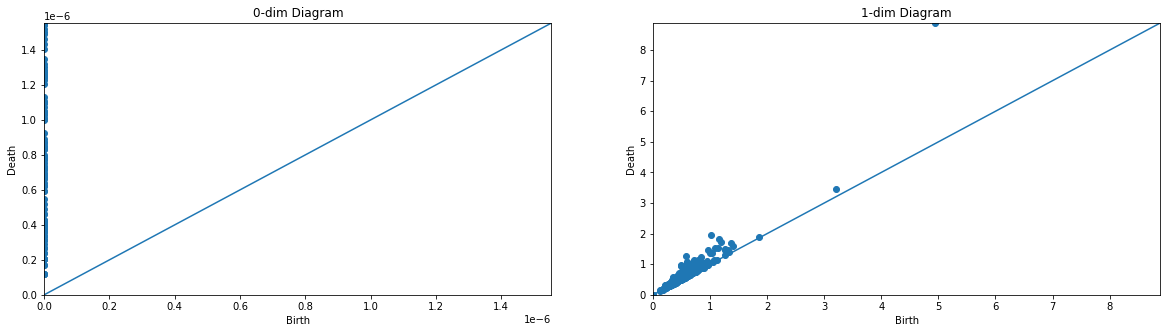

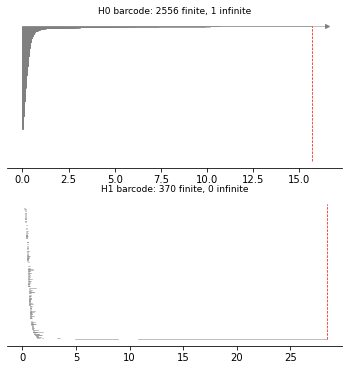

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



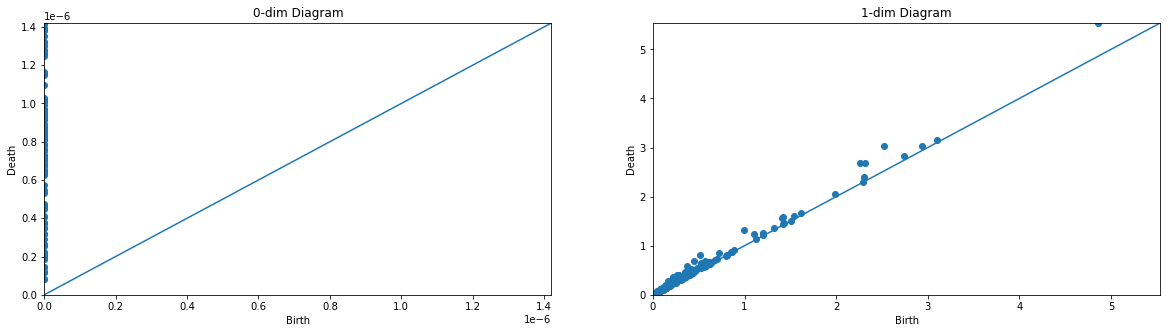

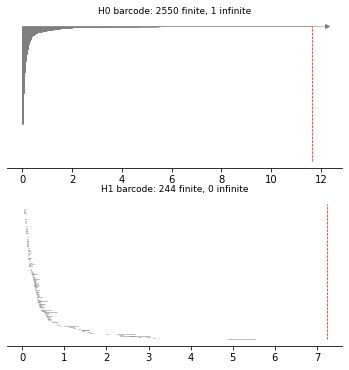

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



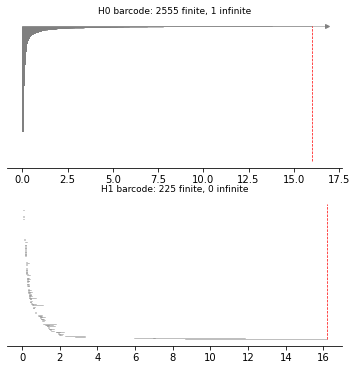

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



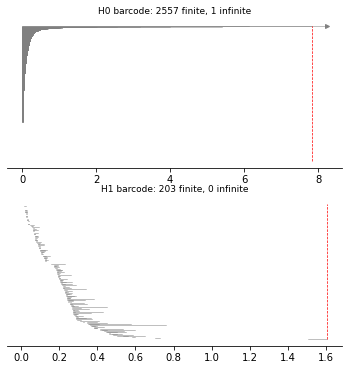

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



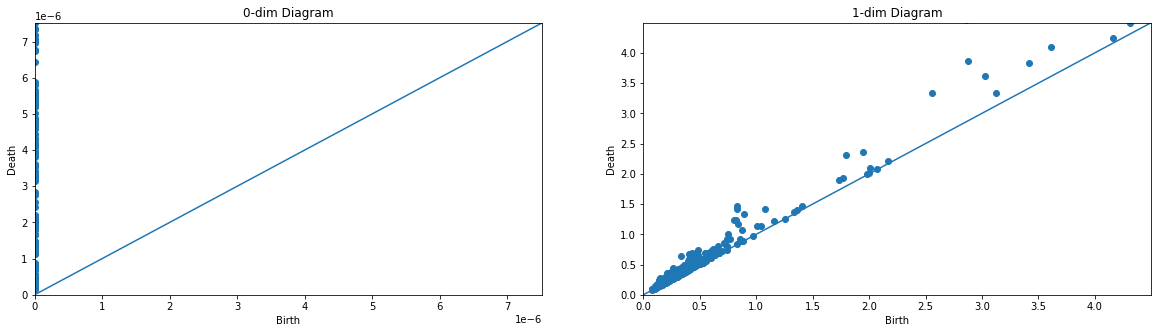

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



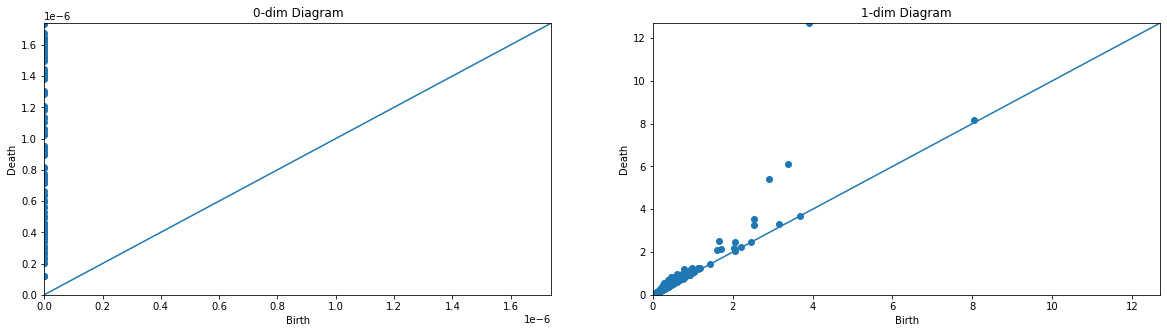

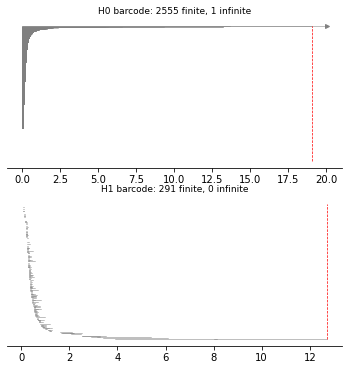

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



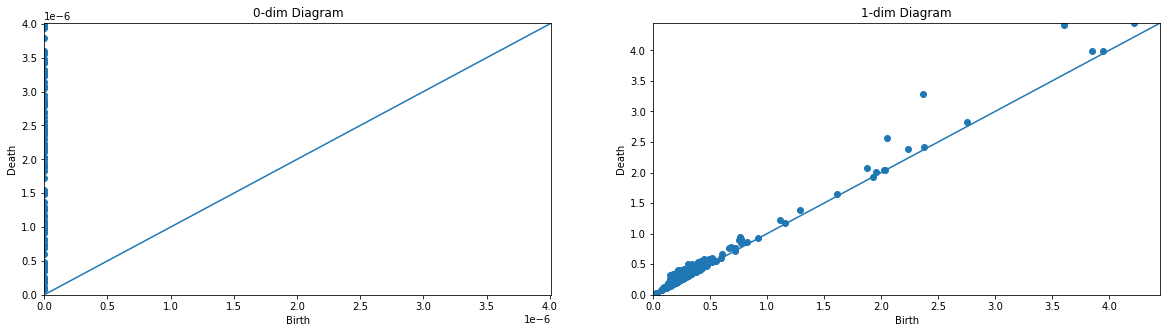

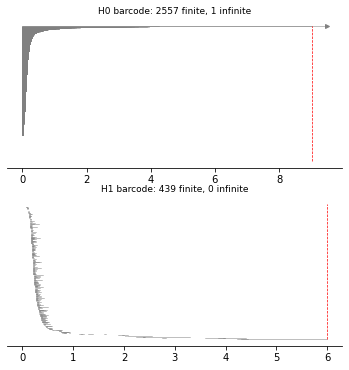

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



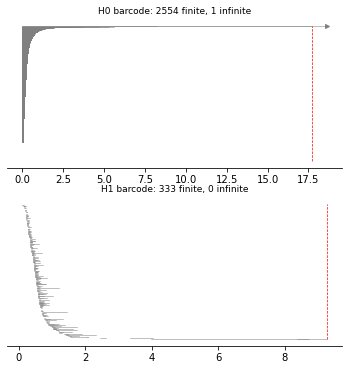

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2560, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



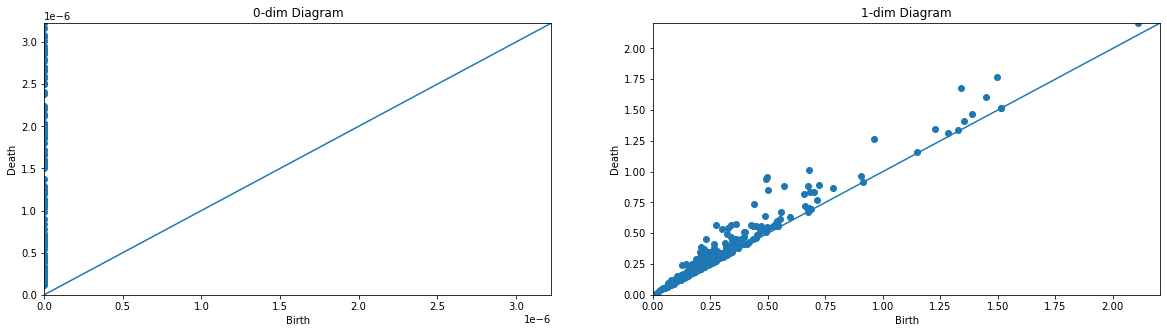

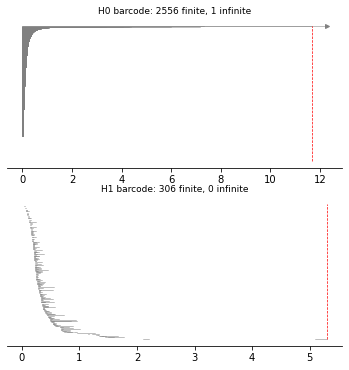

In [76]:
for i in range(10):
    X = data[:, i*10 : (i*10+10)]
    X_diagram, X_barcode = iso_tda(X)

### for block1:

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



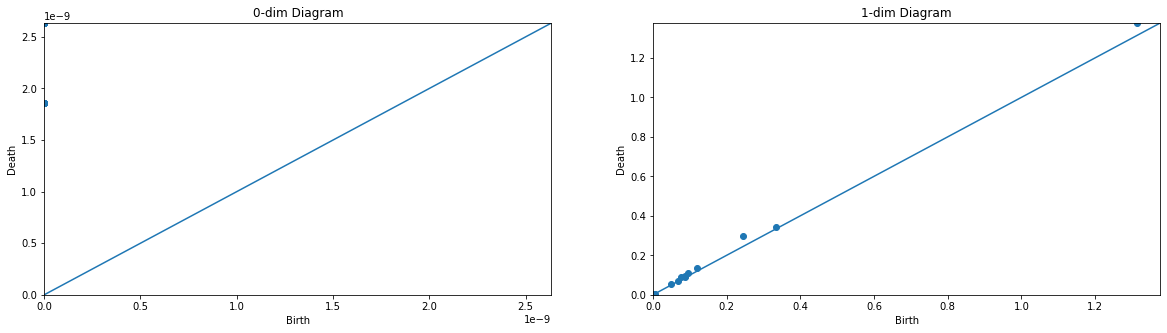

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



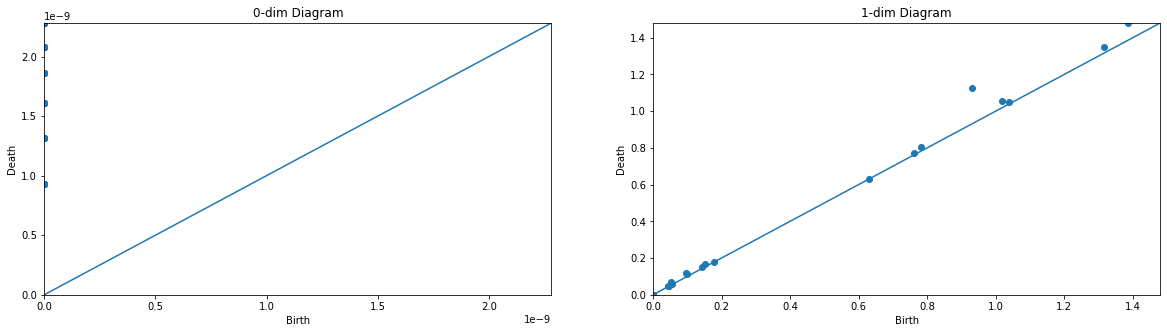

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



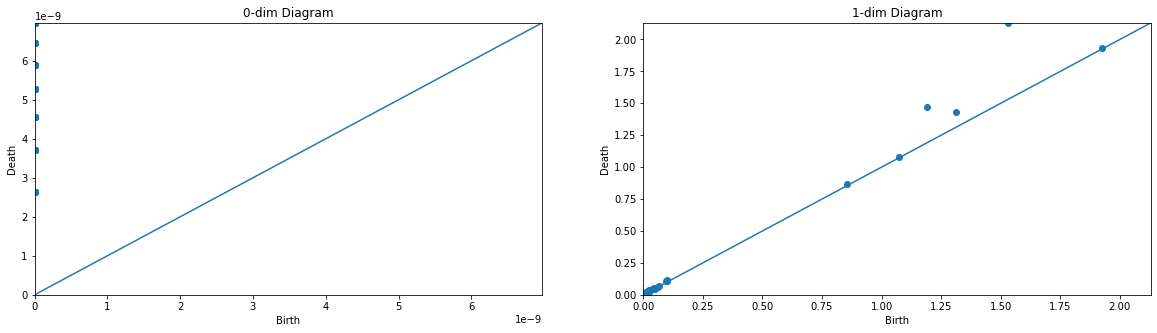

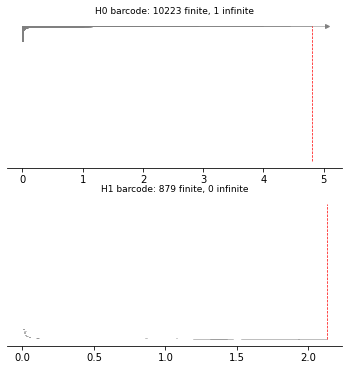

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



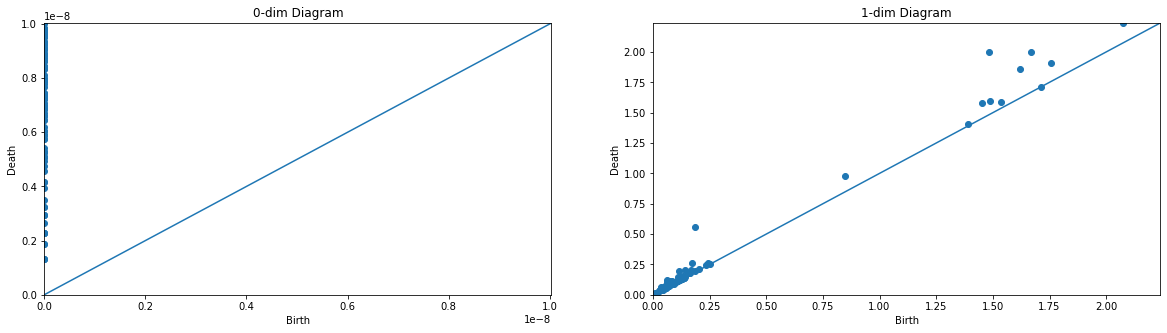

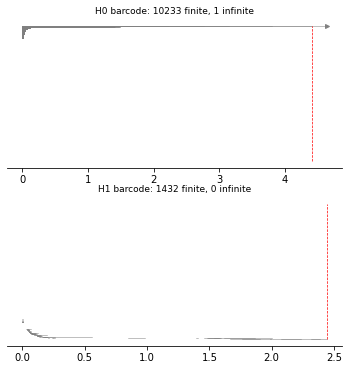

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



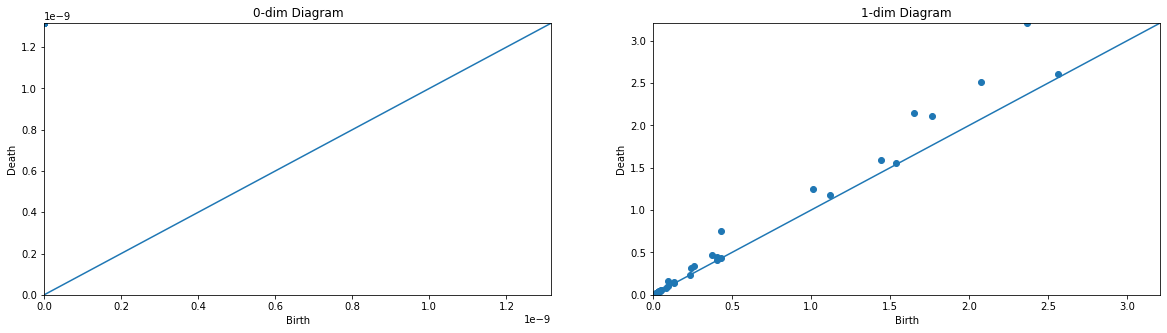

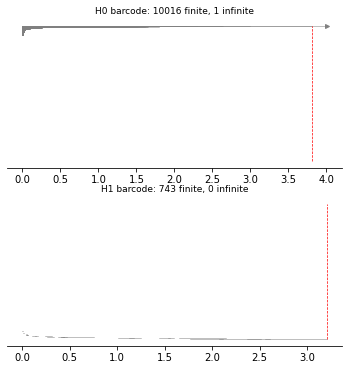

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



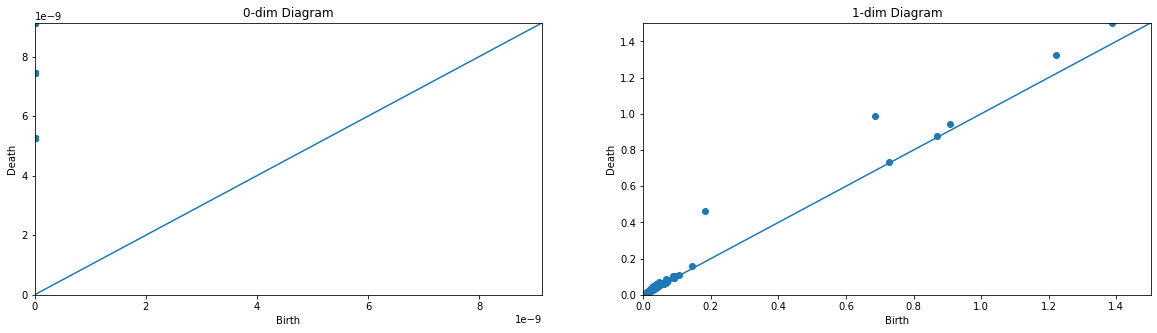

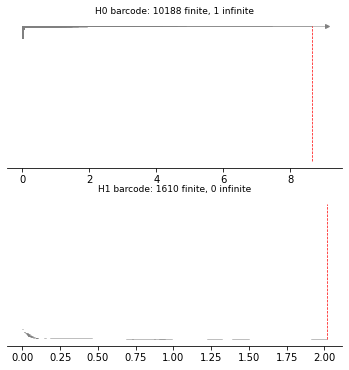

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



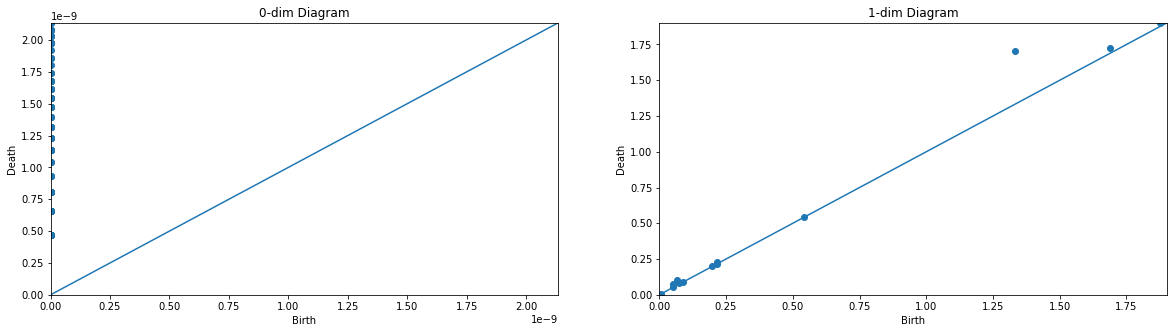

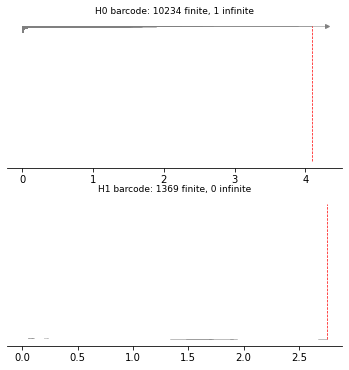

In [46]:
# X_diagrams = []
# X_barcodes = []
for i in range(7):
    X = data[:, i*10 : (i*10+10)]
    X_diagram, X_barcode = iso_tda(X)
#     X_diagrams.append(X_diagram)
#     X_barcodes.append(X_barcode)

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



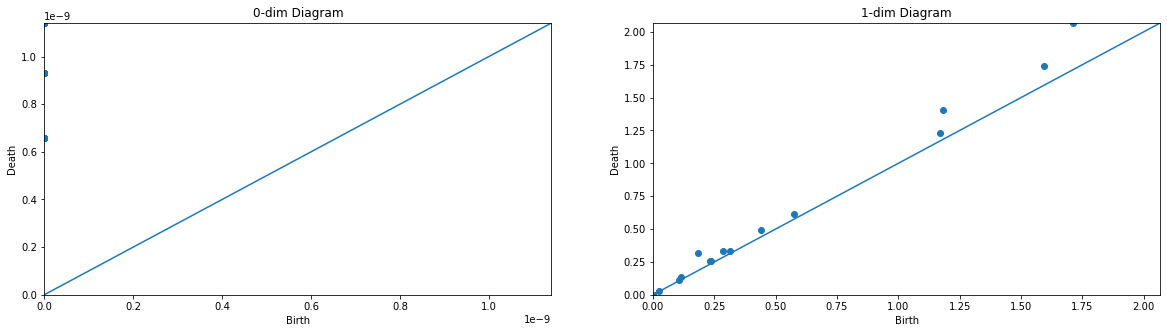

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 10)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



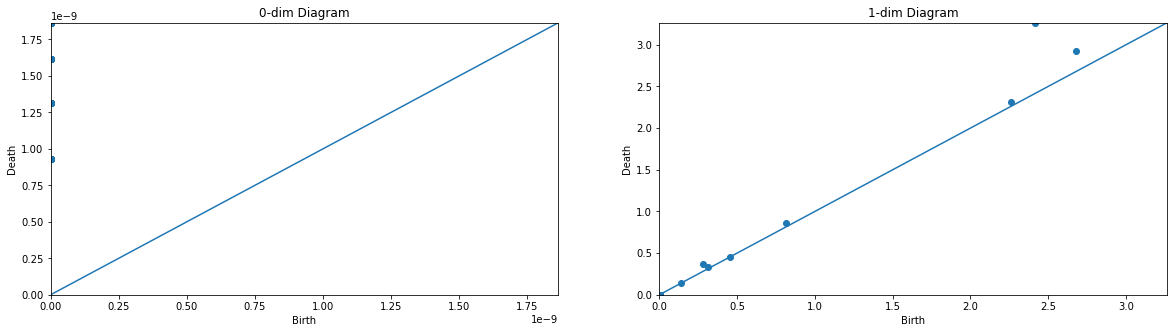

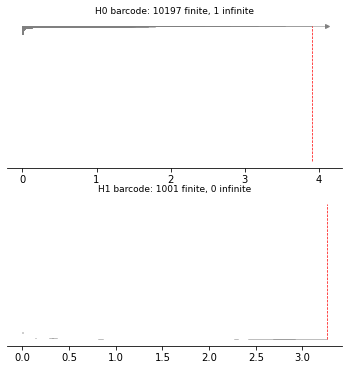

In [47]:
for i in range(8, 10):
    X = data[:, i*10 : (i*10+10)]
    X_diagram, X_barcode = iso_tda(X)

SHAPE (10240, 3)


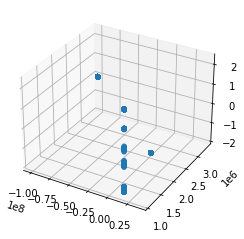

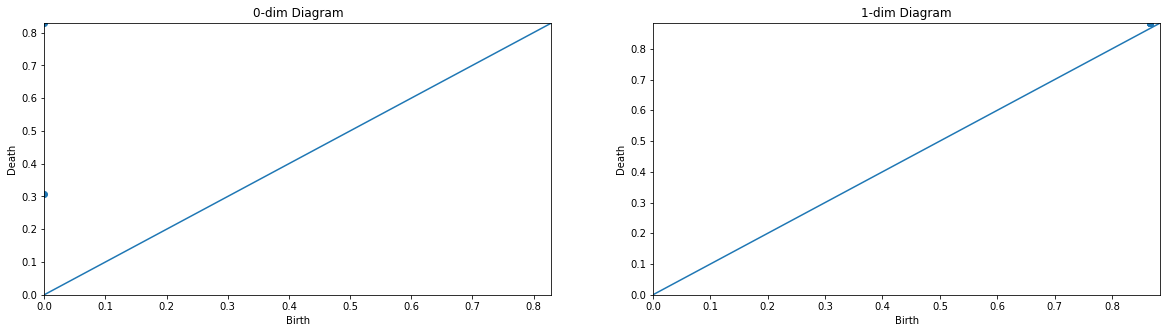

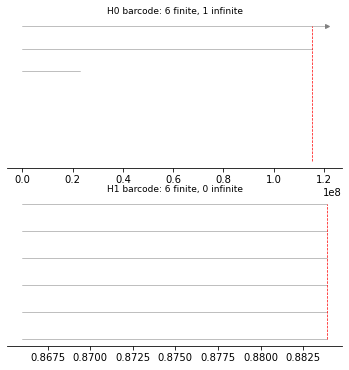

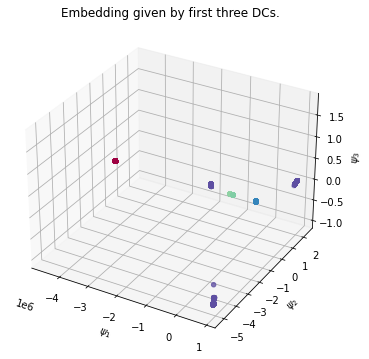

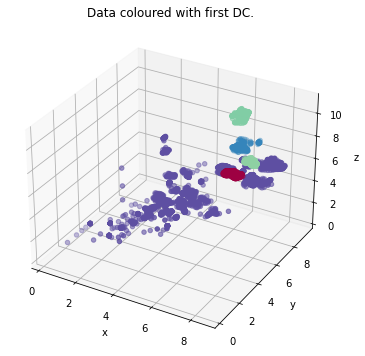

SHAPE (10240, 3)


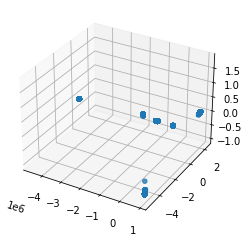

KeyboardInterrupt: 

In [39]:
for i in range(10):
    X = data[:, i*10 : (i*10+10)]
    X_diagram, X_barcode = diffusion_tda(X)

In [47]:
import kmapper as km
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import cluster
from kmapper import jupyter 

In [ ]:
diagrams, barcode = iso_tda(data)

KeplerMapper(verbose=2)
..Composing projection pipeline of length 1:
	Projections: Isomap(n_components=3, n_jobs=-1)
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (10240, 40)

..Projecting data using: 
	Isomap(n_components=3, n_jobs=-1)



In [49]:
graph = mapper.map(data_projected, data, cover=km.Cover(n_cubes = 12, perc_overlap=0.25))

NameError: name 'mapper' is not defined

In [ ]:
# graph = mapper.map(data_projected,
#                    clusterer=cluster.AgglomerativeClustering(n_clusters=10,
#                                                              linkage="complete",
#                                                              affinity="cosine"),)

In [ ]:
html = mapper.visualize(graph,
                        path_html="artificial.html",
                        X=data_projected,
                        title="TDA for Artificial Neurons",)
jupyter.display(path_html="artificial.html")